In [8]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import copy
import pandas as pd
import time

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS #, HDBSCAN
# HDBSCAN is New in version 1.3.
from sklearn.metrics import silhouette_score
#from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

from utils.subspace_clustering_helper_funcs import *

In [22]:
import warnings
warnings.filterwarnings('ignore')
# C:\Users\kdmen\miniconda3\envs\fl_torch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning warnings.warn(

- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold

## Loading in the data

In [9]:
## Pickle is theoretically faster for Python...

# Kai's laptop
#data_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\"
# BRC Desktop
data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\Both_PCA40\\"

print("Loading")
start_time = time.time()

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']

PCA_df = pd.read_pickle(data_path+'$BStand_PCA40_IMUEMG_df.pkl')
metadata_cols_df = pd.read_pickle('D:\\Kai_MetaGestureClustering_24\\saved_datasets\\metadata_cols_df.pkl')

# Dropping the metadata when we read it in!
training_u_df = pd.read_pickle(data_path+'training_users_df.pkl').drop(metadata_cols, axis=1)
test_users_df = pd.read_pickle(data_path+'test_users_df.pkl').drop(metadata_cols, axis=1)

end_time = time.time()
print(f"Completed in {end_time - start_time}s")

Loading
Completed in 0.17815780639648438s


In [10]:
print(training_u_df.shape)
training_u_df.head()

(160000, 40)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.030730,-0.052976,0.176556,-0.048078,-0.390790,-2.119829,0.875118,-0.187689,0.685004,0.870080,...,-0.253283,-0.248582,0.283079,-0.178321,-0.087101,-0.027081,0.000970,0.124380,-0.100580,-0.119294
1,0.077533,-0.108477,0.128970,-0.032167,-0.182756,-1.604412,0.701500,-0.068443,0.667338,1.098287,...,-0.423007,0.097453,0.184025,0.027788,0.112078,-0.414946,-0.210576,0.277156,0.051190,-0.039548
2,0.268279,-0.369027,0.268750,0.105239,-0.190292,-2.093812,1.012038,-0.080958,0.510502,0.758940,...,-0.311882,0.138655,-0.067485,0.201313,-0.051898,-0.479894,-0.079818,0.398142,0.058779,-0.095208
3,-0.106155,-0.291958,0.270681,0.035371,-0.204143,-2.314179,0.801514,-0.155267,0.519967,0.523683,...,-0.585487,-0.100021,0.082335,0.042349,-0.179251,-0.106235,-0.034940,0.386797,-0.034177,-0.132103
4,0.673338,-0.345606,0.246740,0.238184,0.948365,-0.041183,0.279347,0.034288,1.173712,2.115719,...,-0.262556,0.011353,-0.353489,0.209535,-0.402682,-0.353866,0.106203,0.366540,0.218785,-0.080414


In [11]:
print(test_users_df.shape)
test_users_df.head()

(44800, 40)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
6400,0.107265,0.022380,0.464623,-0.050936,-0.557899,-1.916403,0.836042,0.119926,0.838761,2.358403,...,0.827032,0.742273,0.035545,-0.341432,0.333015,0.422960,0.161330,-0.023112,0.228526,0.139422
6401,0.126461,0.051763,0.408197,-0.011168,-0.263406,-1.913741,0.817645,0.029220,1.005925,2.244518,...,0.835731,0.728500,-0.048592,-0.389147,0.283640,0.405166,0.203848,-0.011298,0.267878,0.190739
6402,0.097546,-0.039552,0.514226,0.076121,-0.452843,-1.912188,0.754206,0.005264,0.816782,2.384358,...,0.753895,0.763532,-0.086588,-0.353740,0.295455,0.397759,0.197176,-0.073361,0.230636,0.201310
6403,0.083305,0.022732,0.334234,0.140694,-0.401044,-1.862701,0.758190,0.042743,1.028129,2.424647,...,0.808945,0.945273,-0.252243,-0.361014,0.157914,0.357221,0.178216,-0.064256,0.221917,0.192357
6404,0.076565,0.010458,0.417453,-0.052934,-0.475552,-1.837508,0.705276,0.091957,0.846170,2.359285,...,0.800235,1.001427,-0.077868,-0.354334,0.216455,0.376026,0.126790,-0.052310,0.218843,0.171677


Let's actually re-arrange to make them 3D matrices...

In [12]:
num_rows_per_gesture = 64 # From the interp
num_gestures = len(PCA_df) // num_rows_per_gesture
num_features = PCA_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(PCA_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Convert DataFrame to NumPy array
data_np = PCA_df.to_numpy()
# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns)
PCA_np = data_np.reshape(num_gestures, num_rows_per_gesture, num_features)

#PCA_np = PCA_df.to_numpy()
flattened_PCA = PCA_np.reshape(num_gestures, -1)

Now proceed with the clustering

In [13]:
# Maximum number of components
max_clusters = 20 # Original dataset size

# Create a combined range: 2-20
num_clusters_range = list(range(2, max_clusters+1))

In [14]:
PCA_np.shape

(3200, 64, 40)

In [15]:
flattened_PCA.shape

(3200, 2560)

In [16]:
#import hdbscan
#HDBSCAN is an extension of DBSCAN that automatically determines the number of clusters and identifies noise points.
#It constructs a hierarchical clustering based on density and then extracts the clusters using a stable cut-off point.
#It's suitable for datasets with varying cluster densities and sizes.

# Create HDBSCAN object
#hdbscan = hdbscan.HDBSCAN(min_cluster_size=5)

# Fit the model and predict clusters
#clusters = hdbscan.fit_predict(flattened_PCA)

## Metrics That Don't Require Ground Truth Labels
- Silhouette Score: Measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It ranges from -1 to 1, where a higher score indicates better clustering.
- Davies–Bouldin Index: Represents the average similarity between each cluster and its most similar cluster, where lower values indicate better clustering.
- Calinski-Harabasz Index (Variance Ratio Criterion): Computes the ratio of the between-cluster dispersion to the within-cluster dispersion. Higher values indicate better clustering.
- Dunn Index: Measures the compactness and separation of clusters. It is the ratio of the smallest distance between observations not in the same cluster to the largest intra-cluster distance. Higher values are preferred.
- Gap Statistics: Measures the difference between the intra-cluster dispersion of the data and that expected under a null reference distribution. It helps in determining the optimal number of clusters.

In [17]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
import numpy as np

def dunn_index(X, labels):
    # Compute pairwise distances between points in the same cluster
    intra_cluster_distances = []
    for cluster_label in np.unique(labels):
        cluster_points = X[labels == cluster_label]
        if len(cluster_points) > 1:
            nearest_neighbors = NearestNeighbors(n_neighbors=2).fit(cluster_points)
            distances, _ = nearest_neighbors.kneighbors()
            intra_cluster_distances.extend(distances[:, 1])

    # Compute pairwise distances between points in different clusters
    inter_cluster_distances = []
    for i in range(len(X)):
        for j in range(i + 1, len(X)):
            if labels[i] != labels[j]:
                inter_cluster_distances.append(np.linalg.norm(X[i] - X[j]))

    # Compute Dunn Index
    min_inter_cluster_distance = min(inter_cluster_distances)
    max_intra_cluster_distance = max(intra_cluster_distances)
    return min_inter_cluster_distance / max_intra_cluster_distance

def gap_statistics(X, labels):
    # Compute within-cluster dispersion
    Wk = np.sum([np.mean(np.linalg.norm(X[np.where(labels == k)] - np.mean(X[np.where(labels == k)], axis=0), axis=1)) for k in np.unique(labels)])

    # Generate reference datasets and compute within-cluster dispersion for each
    reference_Wk = []
    for i in range(10):
        random_data = np.random.rand(*X.shape)
        reference_labels = KMeans(n_clusters=len(np.unique(labels))).fit_predict(random_data)
        reference_Wk.append(np.sum([np.mean(np.linalg.norm(random_data[np.where(reference_labels == k)] - np.mean(random_data[np.where(reference_labels == k)], axis=0), axis=1)) for k in np.unique(reference_labels)]))
    
    # Compute Gap Statistics
    gap = np.mean(np.log(reference_Wk)) - np.log(Wk)
    return gap


In [20]:
def run_clustering_algorithm(clustering_algo_str, X, num_clusters=2, eps=0.5, min_samples=5):
    if clustering_algo_str.upper() == 'KMEANS':
        model = KMeans(n_clusters=num_clusters, random_state=42)
    elif clustering_algo_str.upper() == 'DBSCAN':
        #It's suitable for datasets with complex cluster shapes and noise.
        #However, it may struggle with clusters of varying densities or high-dimensional data.
        #--> Probably both are true for us?...
        model = DBSCAN(eps=eps, min_samples=min_samples)
    elif clustering_algo_str.upper() == 'OPTICS':
        #It's suitable for datasets with varying cluster densities and non-convex shapes.
        #It can handle noise and doesn't require specifying the number of clusters in advance.
        model = OPTICS(eps=eps, min_samples=min_samples)
    elif clustering_algo_str.upper() == 'AGGLO':
        model = AgglomerativeClustering(n_clusters=n)
    else:
        raise ValueError(f"Clustering algo {clustering_algo_str} not recognized")
    
    labels = model.fit_predict(X)

    # Compute clustering metrics
    silhouette = silhouette_score(X, labels)
    db_index = davies_bouldin_score(X, labels)
    ch_index = calinski_harabasz_score(X, labels)
    di_index = dunn_index(X, labels)
    gap_stat = gap_statistics(X, labels)

    return silhouette, db_index, ch_index, di_index, gap_stat

# K-Means

In [23]:
km_silhouette_lst=[]
km_davies_bouldin_lst=[]
km_cali_har_lst=[]
km_dunn_index_lst=[]
km_gap_stat_lst=[]
for n in num_clusters_range:
    print(f"{n}/{num_clusters_range[-1]}")
    silhouette, db_index, ch_index, di_index, gap_stat = run_clustering_algorithm('KMeans', flattened_PCA, num_clusters=n)
    km_silhouette_lst.append(silhouette)
    km_davies_bouldin_lst.append(db_index)
    km_cali_har_lst.append(ch_index)
    km_dunn_index_lst.append(di_index)
    km_gap_stat_lst.append(gap_stat)

2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
20/20


## Silhouette Score
- 1 is the best, -1 is the worst, 0 indicates overlapping clusters. Negative means that a sample has been assigned to the wrong cluster, as a different cluster is more similar
> HIGHER IS BETTER

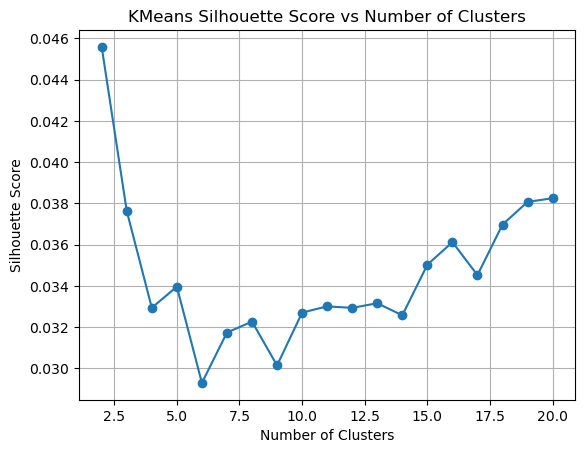

In [24]:
# Plot the silhouette scores
plt.plot(num_clusters_range, km_silhouette_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('KMeans Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

## Davies-Bouldin score
- The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score.
- The minimum score is zero, with lower values indicating better clustering.
> LOWER IS BETTER

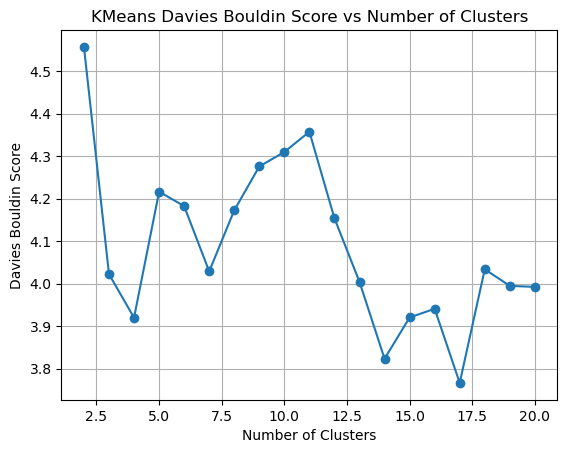

In [25]:
# Plot the Davies-Bouldin score
plt.plot(num_clusters_range, km_davies_bouldin_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies Bouldin Score')
plt.title('KMeans Davies Bouldin Score vs Number of Clusters')
plt.grid(True)
plt.show()

## Calinski and Harabasz score / Variance Ratio Criterion
- The score is defined as ratio of the sum of between-cluster dispersion and of within-cluster dispersion.
- The value of k that yields the maximum CH index is chosen as the optimal number of clusters.
> HIGHER IS BETTER

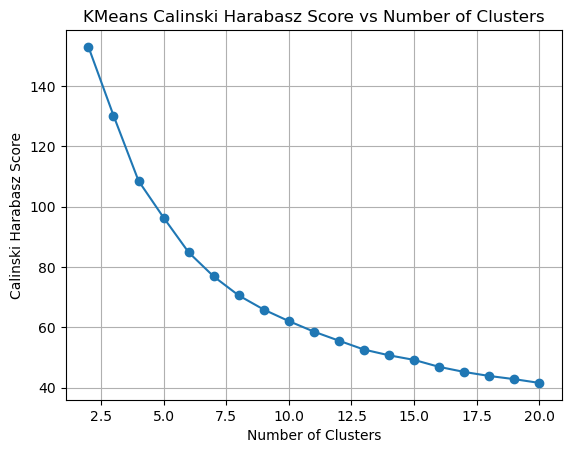

In [26]:
# Plot the Calinski and Harabasz score
plt.plot(num_clusters_range, km_cali_har_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.title('KMeans Calinski Harabasz Score vs Number of Clusters')
plt.grid(True)
plt.show()

## Dunn Index
- Measures the compactness and separation of clusters. It is the ratio of the smallest distance between observations not in the same cluster to the largest intra-cluster distance. 
> HIGHER IS BETTER

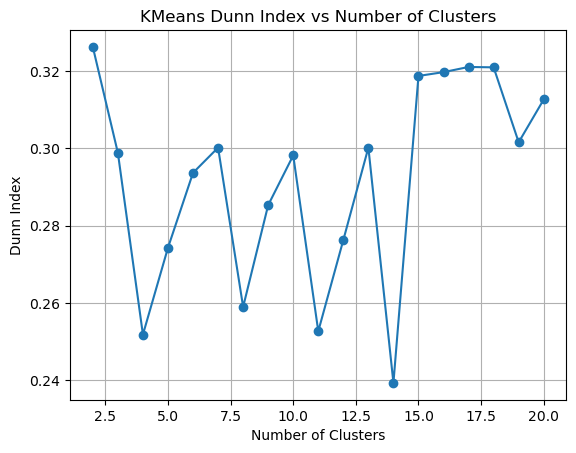

In [27]:
# Plot the Dunn Index
plt.plot(num_clusters_range, km_dunn_index_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Dunn Index')
plt.title('KMeans Dunn Index vs Number of Clusters')
plt.grid(True)
plt.show()

## Gap Statistic / Criterion
- Measures the difference between the intra-cluster dispersion of the data and that expected under a null reference distribution.
> HIGHER IS BETTER

> Not sure what mine being negative implies... presumably is broken? Gap(k) = E[log(W_k)] - log(W_k)

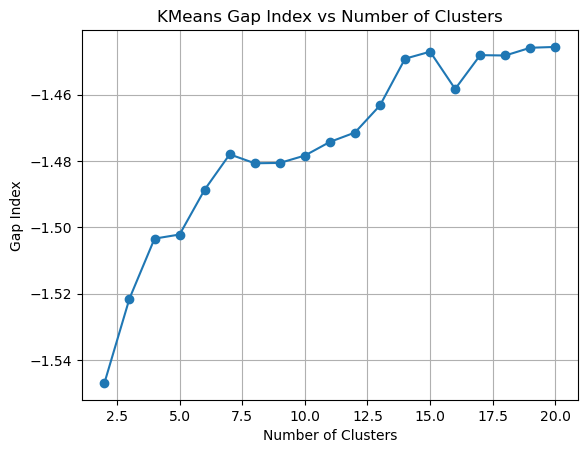

In [28]:
# Plot the Gap Statistic
plt.plot(num_clusters_range, km_gap_stat_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Gap Index')
plt.title('KMeans Gap Index vs Number of Clusters')
plt.grid(True)
plt.show()

# Agglomerative

In [29]:
ag_silhouette_lst=[]
ag_davies_bouldin_lst=[]
ag_cali_har_lst=[]
ag_dunn_index_lst=[]
ag_gap_stat_lst=[]
for n in num_clusters_range:
    print(f"{n}/{num_clusters_range[-1]}")
    silhouette, db_index, ch_index, di_index, gap_stat = run_clustering_algorithm('Agglo', flattened_PCA, num_clusters=n)
    ag_silhouette_lst.append(silhouette)
    ag_davies_bouldin_lst.append(db_index)
    ag_cali_har_lst.append(ch_index)
    ag_dunn_index_lst.append(di_index)
    ag_gap_stat_lst.append(gap_stat)

2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
20/20


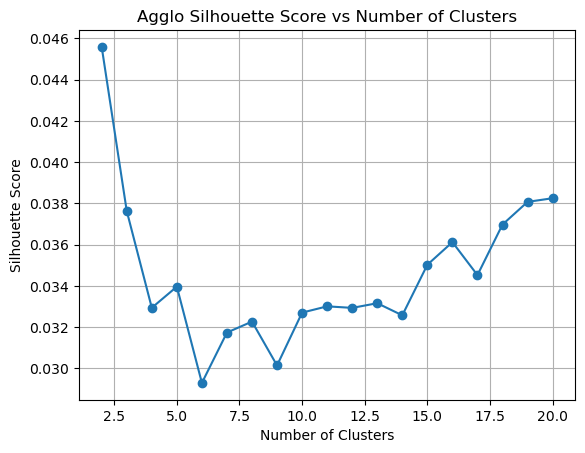

In [30]:
# Plot the silhouette scores
plt.plot(num_clusters_range, km_silhouette_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Agglo Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

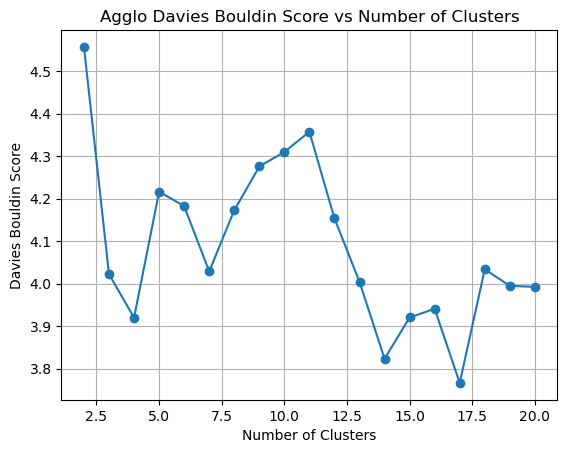

In [31]:
# Plot the Davies-Bouldin score
plt.plot(num_clusters_range, km_davies_bouldin_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies Bouldin Score')
plt.title('Agglo Davies Bouldin Score vs Number of Clusters')
plt.grid(True)
plt.show()

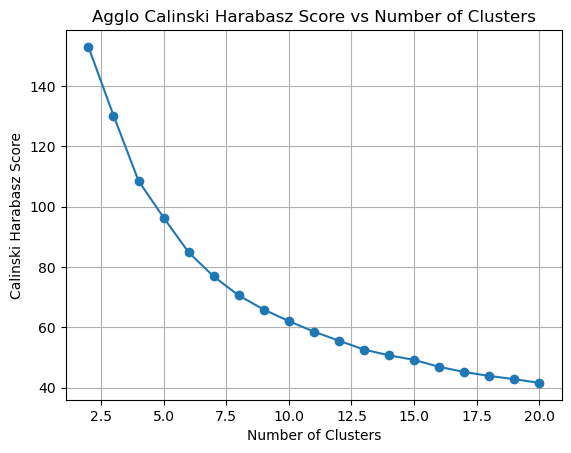

In [32]:
# Plot the Calinski and Harabasz score
plt.plot(num_clusters_range, km_cali_har_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.title('Agglo Calinski Harabasz Score vs Number of Clusters')
plt.grid(True)
plt.show()

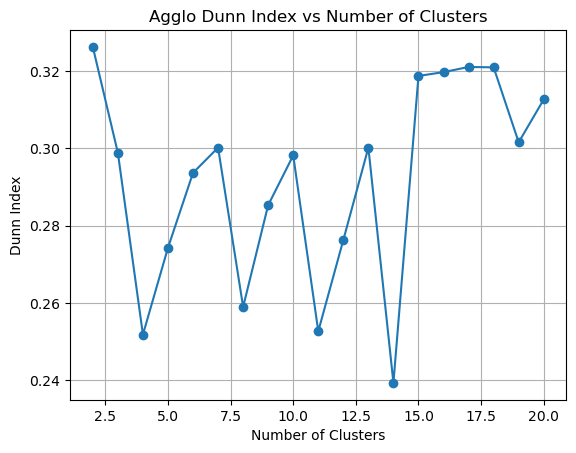

In [33]:
# Plot the Dunn Index
plt.plot(num_clusters_range, km_dunn_index_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Dunn Index')
plt.title('Agglo Dunn Index vs Number of Clusters')
plt.grid(True)
plt.show()

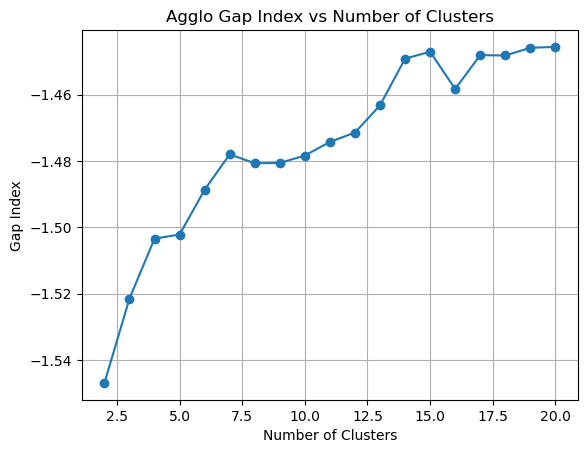

In [34]:
# Plot the Gap Statistic
plt.plot(num_clusters_range, km_gap_stat_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Gap Index')
plt.title('Agglo Gap Index vs Number of Clusters')
plt.grid(True)
plt.show()

# OPTICS
OPTICS doesnt wanna run, I didn't really look into what min_samples does or is supposed to be. Min_samples sets how many samples is required for a point to be its own centroid, I'm not sure why labels is only showing one class for OPTICS...

In [20]:
opt_silhouette_lst=[]
opt_davies_bouldin_lst=[]
opt_cali_har_lst=[]
opt_dunn_index_lst=[]
opt_gap_stat_lst=[]
# Eps is only used for DBSCAN, or when OPTICS uses DBSCAN for its clustering (it deosnt by default)
#eps_conditions=[0.1, 0.25, 0.5, 0.75, 1.0]
min_samples_conditions=[1,3,5,10]
#for ep in eps_conditions:
for ms in min_samples_conditions:
    print(f"min_samples={ms}") #eps={ep}, 
    silhouette, db_index, ch_index, di_index, gap_stat = run_clustering_algorithm('OPTICS', flattened_PCA, min_samples=ms) #eps=ep, 
    opt_silhouette_lst.append(silhouette)
    opt_davies_bouldin_lst.append(db_index)
    opt_cali_har_lst.append(ch_index)
    opt_dunn_index_lst.append(di_index)
    opt_gap_stat_lst.append(gap_stat)

min_samples=1


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

## Dynamic Time Warping (DTW)
> Need to install some other package...

In [ ]:
#from tslearn.clustering import TimeSeriesKMeans
#from tslearn.metrics import dtw
#from tslearn.preprocessing import TimeSeriesScalerMeanVariance
#
## Scale the time series data
#scaler = TimeSeriesScalerMeanVariance()
#scaled_data = scaler.fit_transform(gestures_data)
#
## Apply KMeans with DTW as a metric
#dtw_kmeans = TimeSeriesKMeans(n_clusters=5, metric="dtw", random_state=42)
#dtw_labels = dtw_kmeans.fit_predict(scaled_data)
#
## Evaluate clustering with silhouette score
#dtw_silhouette = silhouette_score(scaled_data.reshape(num_gestures, -1), dtw_labels)
#
#print(f"DTW KMeans Silhouette Score: {dtw_silhouette}")